In [ ]:
pip install geopandas folium pandas pyarrow fastparquet

## 1) Total Crimes by LAPD Area

In [ ]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import PowerNorm

df = pd.read_parquet("Crime_Data_from_2020_to_Present.parquet")

# Aggregate crime counts
area_counts = (
    df.groupby("AREA NAME")
    .size()
    .reset_index(name="crime_count")
)

# Normalize function
def normalize_area(name):
    return name.lower().replace(" area", "").replace(".", "").strip()

area_counts["area_norm"] = area_counts["AREA NAME"].apply(normalize_area)

# Load GeoJSON
areas_gdf = gpd.read_file("lapd-divisions.geojson")
areas_gdf = areas_gdf.rename(columns={"name": "AREA NAME"})
areas_gdf["AREA NAME"] = areas_gdf["AREA NAME"] + " Area"
areas_gdf["area_norm"] = areas_gdf["AREA NAME"].apply(normalize_area)

# Merge only once using normalized column
areas_gdf = areas_gdf.merge(
    area_counts[["area_norm", "crime_count"]],
    on="area_norm",
    how="left"
)

areas_gdf["crime_count"] = areas_gdf["crime_count"].fillna(0)

# Verify
# print(areas_gdf[["AREA NAME", "crime_count"]])

# Create Folium map
m = folium.Map(location=[34.05, -118.25], zoom_start=10, tiles="cartodbpositron")

folium.Choropleth(
    geo_data=areas_gdf,
    data=areas_gdf,
    columns=["AREA NAME", "crime_count"],
    key_on="feature.properties.AREA NAME",
    fill_color="YlOrRd",
    fill_opacity=0.75,
    line_opacity=0.4,
    legend_name="Total Crimes by LAPD Area"
).add_to(m)

folium.GeoJson(
    areas_gdf,
    tooltip=folium.GeoJsonTooltip(
        fields=["AREA NAME", "crime_count"],
        aliases=["Area:", "Total Crimes:"],
        localize=True
    )
).add_to(m)
m

## 2) Crime Occurrences Over Time by Area

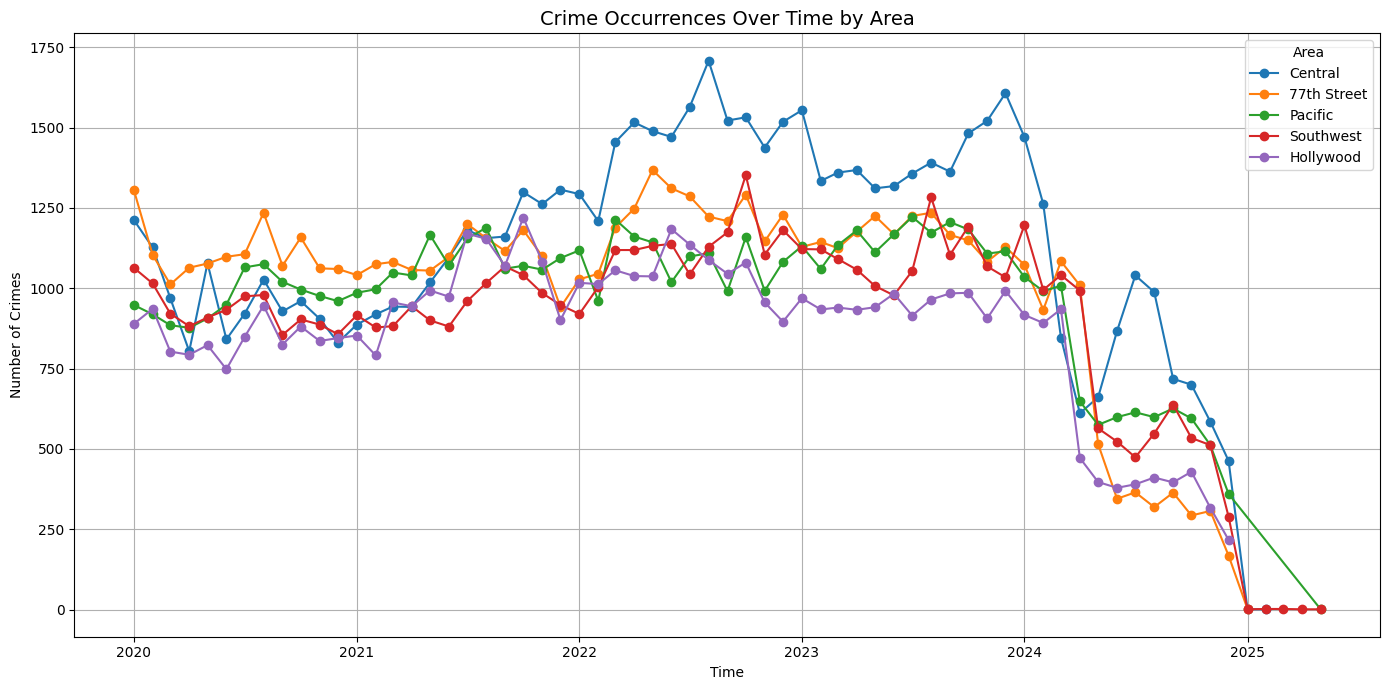

In [ ]:
# 3. Convert DATE OCC to datetime
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['DATE OCC'])

# 4. Create Year-Month column
df['YearMonth'] = df['DATE OCC'].dt.to_period('M')

# 5. Select top N areas by total crime count
TOP_N = 5
top_areas = (
    df['AREA NAME']
    .value_counts()
    .nlargest(TOP_N)
    .index
)

df_top = df[df['AREA NAME'].isin(top_areas)]

# 6. Aggregate crime counts per area per month
area_time = (
    df_top
    .groupby(['YearMonth', 'AREA NAME'])
    .size()
    .reset_index(name='Crime Count')
)

# Convert Period to timestamp for plotting
area_time['YearMonth'] = area_time['YearMonth'].dt.to_timestamp()

# 7. Plot
plt.figure(figsize=(14, 7))

for area in top_areas:
    subset = area_time[area_time['AREA NAME'] == area]
    plt.plot(
        subset['YearMonth'],
        subset['Crime Count'],
        marker='o',
        label=area
    )

plt.title("Crime Occurrences Over Time by Area", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Number of Crimes")
plt.legend(title="Area")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3) Weapon Usage by Victim Descent 

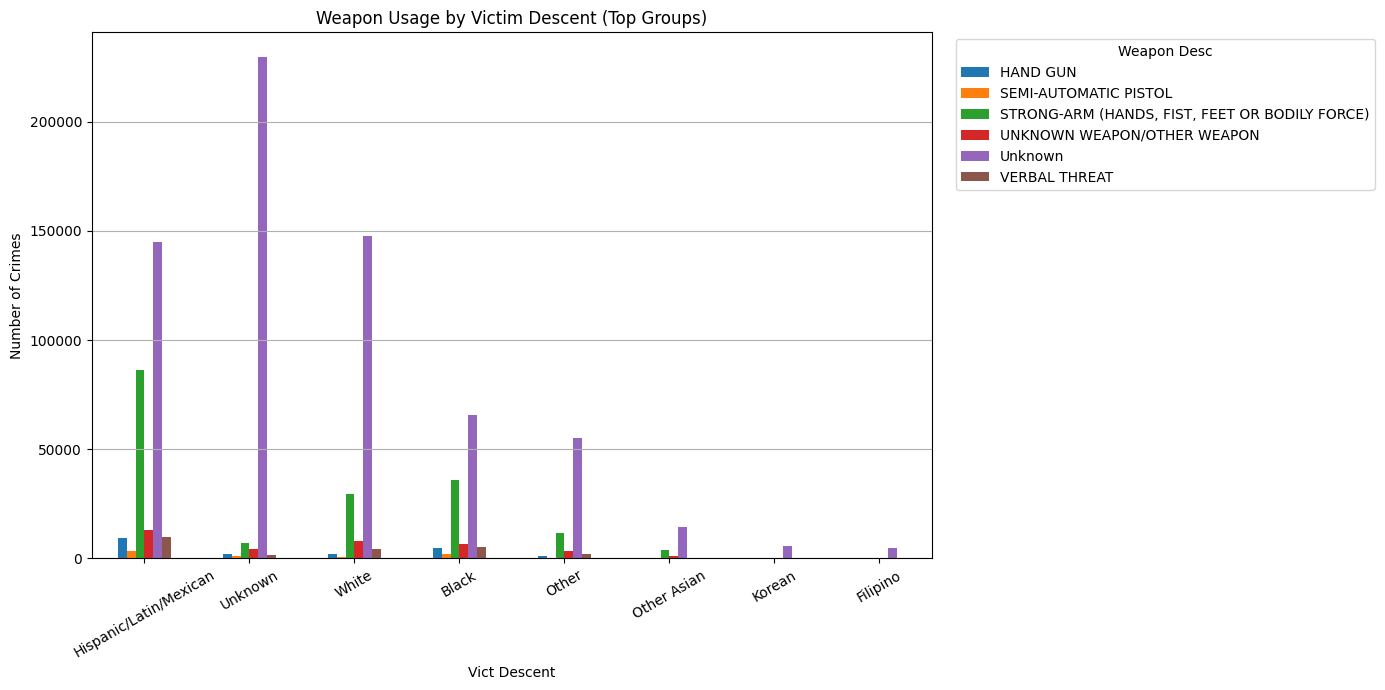

In [ ]:
df.columns = df.columns.str.strip()

# -----------------------------
# Settings (tune for readability)
# -----------------------------
TOP_DESCENTS = 8   # keep chart readable
TOP_WEAPONS  = 6   # keep chart readable

# -----------------------------
# Clean columns
# -----------------------------
df3 = df.copy()
df3 = df3.dropna(subset=["Vict Descent", "Weapon Desc"])

# Optional: remove blank / unknown-like values
df3["Vict Descent"] = df3["Vict Descent"].astype(str).str.strip()
df3["Weapon Desc"]  = df3["Weapon Desc"].astype(str).str.strip()

df3 = df3[(df3["Vict Descent"] != "") & (df3["Weapon Desc"] != "")]

# -----------------------------
# Pick top descents and weapons
# -----------------------------
top_descents = df3["Vict Descent"].value_counts().nlargest(TOP_DESCENTS).index.tolist()
top_weapons  = df3["Weapon Desc"].value_counts().nlargest(TOP_WEAPONS).index.tolist()

df3 = df3[df3["Vict Descent"].isin(top_descents) & df3["Weapon Desc"].isin(top_weapons)]

# -----------------------------
# Aggregate + pivot for grouped bars
# -----------------------------
pivot = (
    df3.groupby(["Vict Descent", "Weapon Desc"])
       .size()
       .reset_index(name="Count")
       .pivot(index="Vict Descent", columns="Weapon Desc", values="Count")
       .fillna(0)
)

# Order rows by total count (nice for readability)
pivot["Total"] = pivot.sum(axis=1)
pivot = pivot.sort_values("Total", ascending=False).drop(columns=["Total"])

# -----------------------------
# Plot grouped bar chart
# -----------------------------
ax = pivot.plot(kind="bar", figsize=(14, 7))

plt.title("Weapon Usage by Victim Descent (Top Groups)")
plt.xlabel("Vict Descent")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=30)
plt.legend(title="Weapon Desc", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## 4) Violent vs Non-Violent Crimes by Area

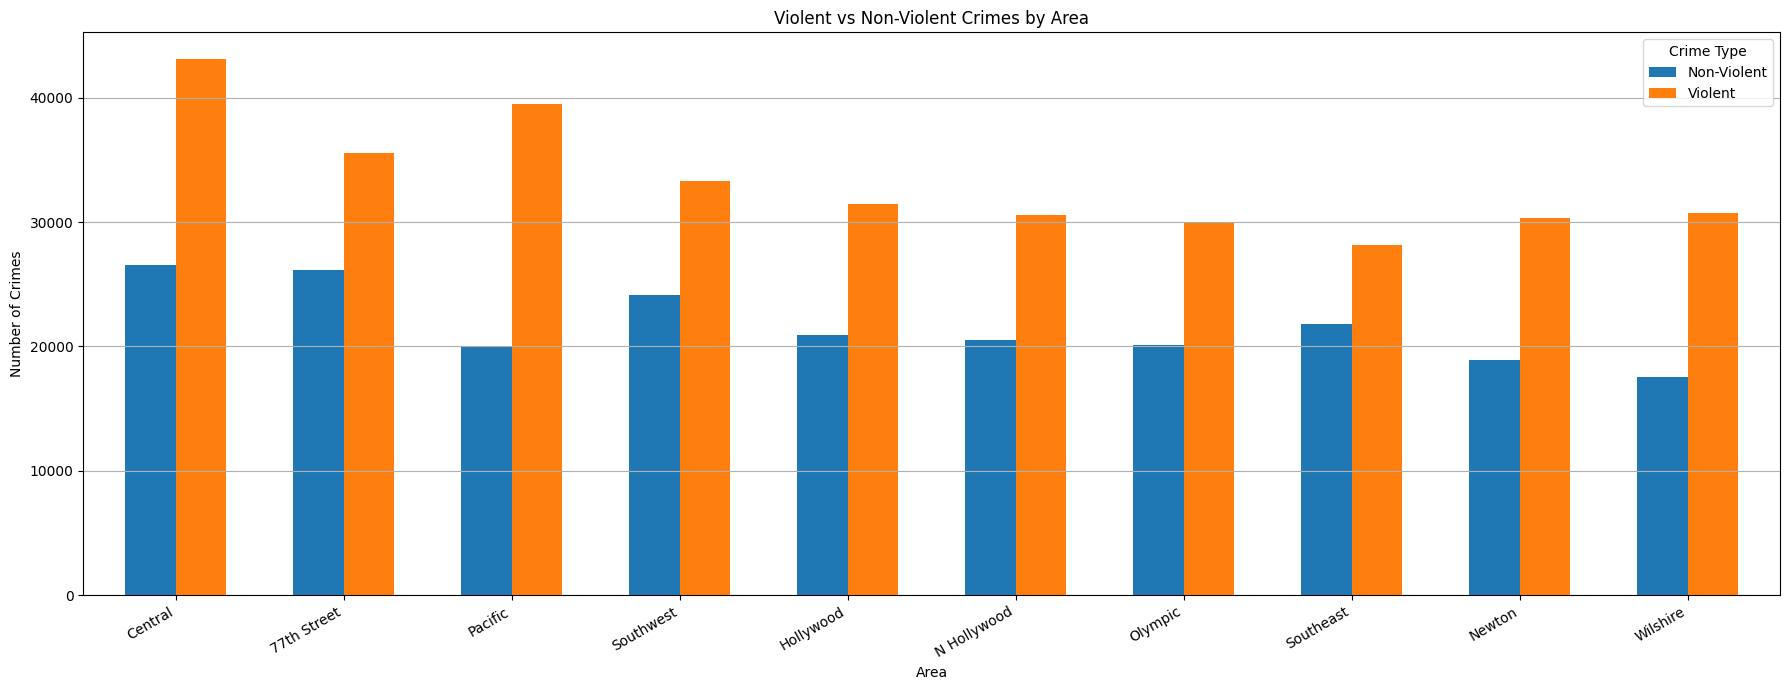

In [ ]:
# -----------------------------
# 1) Create Violent / Non-Violent label
# -----------------------------
df_v = df.copy()

df_v["Part 1-2"] = pd.to_numeric(df_v["Part 1-2"], errors="coerce")
df_v = df_v.dropna(subset=["AREA NAME", "Part 1-2"])

df_v["Crime Type"] = df_v["Part 1-2"].map({
    1: "Violent",
    2: "Non-Violent"
})

df_v = df_v.dropna(subset=["Crime Type"])

# -----------------------------
# 2) Aggregate by Area × Crime Type
# -----------------------------
area_vnv = (
    df_v.groupby(["AREA NAME", "Crime Type"])
        .size()
        .reset_index(name="Crime Count")
)

# Pivot for grouped bars
pivot_vnv = (
    area_vnv.pivot(
        index="AREA NAME",
        columns="Crime Type",
        values="Crime Count"
    )
    .fillna(0)
)

# Sort areas by total crimes
pivot_vnv["Total"] = pivot_vnv.sum(axis=1)
pivot_vnv = pivot_vnv.sort_values("Total", ascending=False).drop(columns="Total")

# Keep top N areas for readability
TOP_N = 10
pivot_vnv = pivot_vnv.head(TOP_N)

# -----------------------------
# 3) Grouped Bar Chart
# -----------------------------
ax = pivot_vnv.plot(
    kind="bar",
    figsize=(18, 7),
    width=0.6
)

plt.title("Violent vs Non-Violent Crimes by Area")
plt.xlabel("Area")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Crime Type")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

## 5) Status × Crime Category 

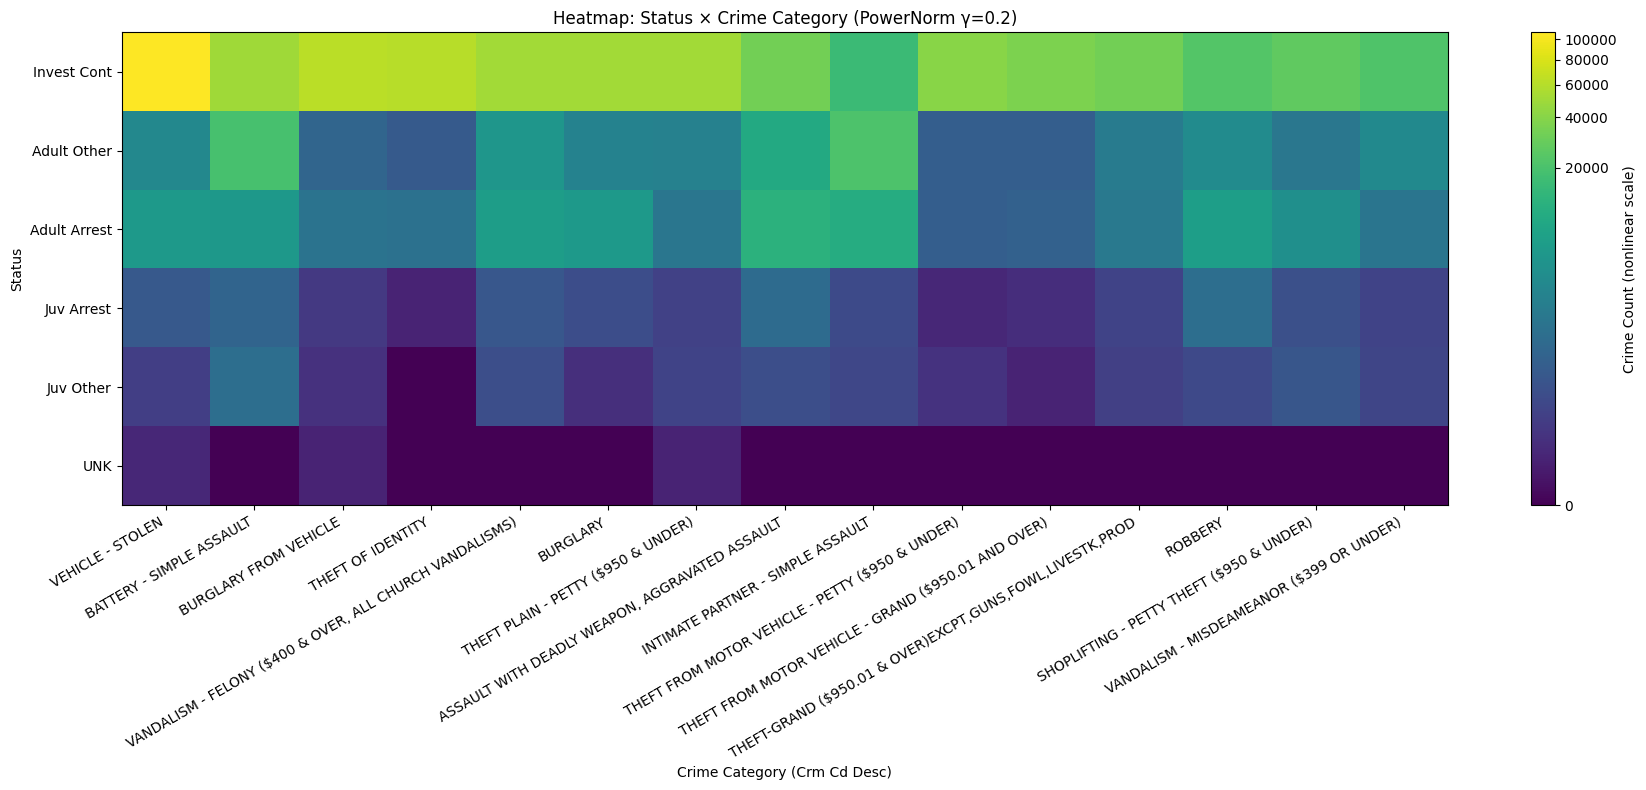

In [ ]:
# -----------------------------
# Settings (tune for readability)
# -----------------------------
TOP_STATUSES = 10
TOP_CRIMES   = 15

# -----------------------------
# Prepare data
# -----------------------------
df5 = df.copy()

# Choose which fields you want to show in the heatmap
status_col = "Status Desc" if "Status Desc" in df5.columns else "Status"
crime_col  = "Crm Cd Desc"

df5 = df5.dropna(subset=[status_col, crime_col])

# Keep only top categories to avoid a huge heatmap
top_statuses = df5[status_col].value_counts().nlargest(TOP_STATUSES).index
top_crimes   = df5[crime_col].value_counts().nlargest(TOP_CRIMES).index

df5 = df5[df5[status_col].isin(top_statuses) & df5[crime_col].isin(top_crimes)]

# -----------------------------
# Create pivot table (counts)
# -----------------------------
heat = pd.pivot_table(
    df5,
    index=status_col,
    columns=crime_col,
    values="DR_NO",      # can be any column; we only need counts
    aggfunc="count",
    fill_value=0
)

# Optional: reorder rows/cols by totals (makes patterns easier to see)
heat = heat.loc[heat.sum(axis=1).sort_values(ascending=False).index]
heat = heat[heat.sum(axis=0).sort_values(ascending=False).index]

# -----------------------------
# Plot heatmap (with nonlinear scaling)
# -----------------------------
gamma = 0.2   # < 1 boosts small values (try 0.4–0.8)

plt.figure(figsize=(18, 8))

im = plt.imshow(
    heat.values,
    aspect="auto",
    norm=PowerNorm(gamma=gamma)
)

plt.title(f"Heatmap: Status × Crime Category (PowerNorm γ={gamma})")
plt.xlabel("Crime Category (Crm Cd Desc)")
plt.ylabel("Status")

plt.xticks(range(len(heat.columns)), heat.columns, rotation=30, ha="right")
plt.yticks(range(len(heat.index)), heat.index)

plt.colorbar(im, label="Crime Count (nonlinear scale)")
plt.tight_layout()
plt.show()

## 6) Crime Category × Area 

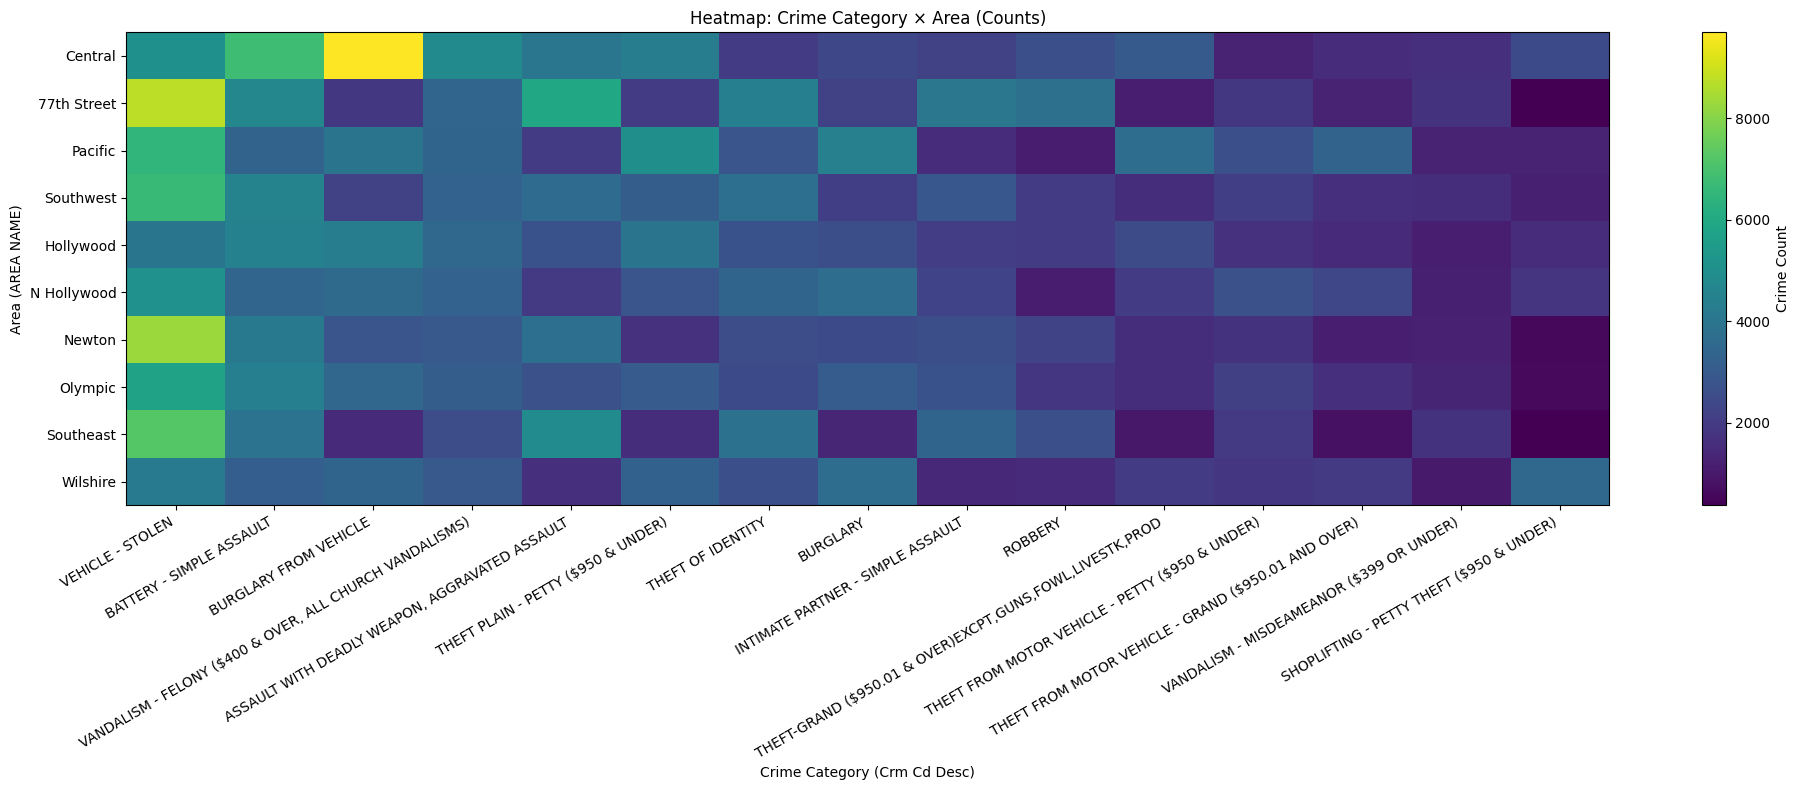

In [ ]:
# -----------------------------
# Settings (adjust if needed)
# -----------------------------
TOP_AREAS = 10
TOP_CATEGORIES = 15

area_col = "AREA NAME"
cat_col  = "Crm Cd Desc"

# -----------------------------
# Prepare data
# -----------------------------
df6 = df.dropna(subset=[area_col, cat_col]).copy()

# Keep only top areas and top crime categories
top_areas = df6[area_col].value_counts().nlargest(TOP_AREAS).index
top_cats  = df6[cat_col].value_counts().nlargest(TOP_CATEGORIES).index

df6 = df6[df6[area_col].isin(top_areas) & df6[cat_col].isin(top_cats)]

# -----------------------------
# Pivot table (counts)
# rows = Areas, columns = Crime categories
# -----------------------------
heat = pd.pivot_table(
    df6,
    index=area_col,
    columns=cat_col,
    values="DR_NO",   # any column works, we just count
    aggfunc="count",
    fill_value=0
)

# Optional: reorder rows/cols by totals (makes it easier to read)
heat = heat.loc[heat.sum(axis=1).sort_values(ascending=False).index]
heat = heat[heat.sum(axis=0).sort_values(ascending=False).index]

# -----------------------------
# Plot heatmap
# -----------------------------
plt.figure(figsize=(20, 8))
plt.imshow(heat.values, aspect="auto")

plt.title("Heatmap: Crime Category × Area (Counts)")
plt.xlabel("Crime Category (Crm Cd Desc)")
plt.ylabel("Area (AREA NAME)")

plt.xticks(range(len(heat.columns)), heat.columns, rotation=30, ha="right")
plt.yticks(range(len(heat.index)), heat.index)

plt.colorbar(label="Crime Count")
plt.tight_layout()
plt.show()

## 7) Crime Category × Weapon

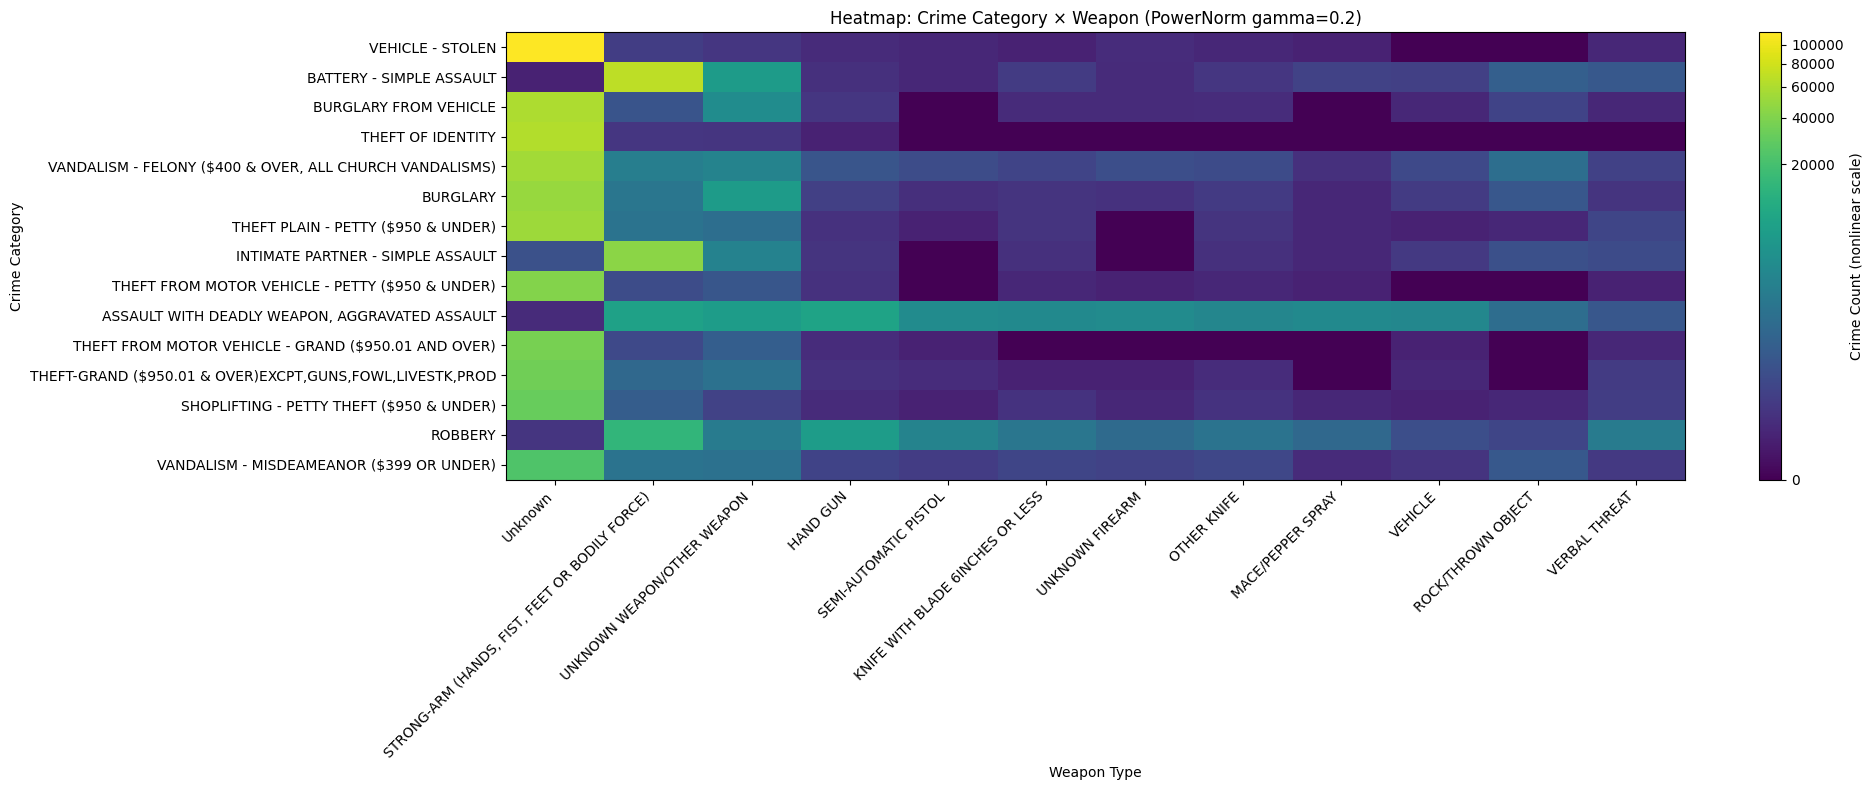

In [ ]:
TOP_CATEGORIES = 15
TOP_WEAPONS = 12

crime_col = "Crm Cd Desc"
weapon_col = "Weapon Desc"

df7 = df.dropna(subset=[crime_col, weapon_col]).copy()
df7[weapon_col] = df7[weapon_col].astype(str).str.strip()
df7[crime_col] = df7[crime_col].astype(str).str.strip()

# Keep top categories/weapons (including Unknown if it's common)
top_crimes = df7[crime_col].value_counts().nlargest(TOP_CATEGORIES).index
top_weapons = df7[weapon_col].value_counts().nlargest(TOP_WEAPONS).index
df7 = df7[df7[crime_col].isin(top_crimes) & df7[weapon_col].isin(top_weapons)]

# Pivot table (counts)
heat = pd.pivot_table(
    df7,
    index=crime_col,
    columns=weapon_col,
    values="DR_NO",
    aggfunc="count",
    fill_value=0
)

# Sort rows/cols by totals (optional but nice)
heat = heat.loc[heat.sum(axis=1).sort_values(ascending=False).index]
heat = heat[heat.sum(axis=0).sort_values(ascending=False).index]

# ---- Nonlinear normalization (boost small differences) ----
# gamma < 1 boosts low values (makes minor differences more visible)
gamma = 0.2  # try 0.4, 0.6, 0.8 depending on how strong you want it

plt.figure(figsize=(20, 8))
im = plt.imshow(
    heat.values,
    aspect="auto",
    norm=PowerNorm(gamma=gamma)
)

plt.title(f"Heatmap: Crime Category × Weapon (PowerNorm gamma={gamma})")
plt.xlabel("Weapon Type")
plt.ylabel("Crime Category")
plt.xticks(range(len(heat.columns)), heat.columns, rotation=45, ha="right")
plt.yticks(range(len(heat.index)), heat.index)
plt.colorbar(im, label="Crime Count (nonlinear scale)")
plt.tight_layout()
plt.show()